In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pickle
import os

In [16]:
data = pd.read_csv("data_nonconcat.csv",header=None)
data = data.sample(frac=1)
data = data.reset_index(drop=True)
labels = data[0]
data = data.drop(0,axis='columns')
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = np.asarray(y_train.values.tolist())
y_train = y_train.reshape(-1,1)
y_test = np.asarray(y_test.values.tolist())
y_test = y_test.reshape(-1,1)

In [17]:
print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8820, 34)
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)


In [119]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import seaborn
import matplotlib.pyplot as plt
def displayStats(model,modelname: str,test: np.ndarray,truth: np.ndarray):
    predictions = model.predict(test) #all of them should have this
    print(modelname+" STATS:")
    print("ACCURACY: "+str(accuracy_score(truth,predictions)))

    cmat = confusion_matrix(truth,predictions)
    # plt.imshow(cmat,cmap='hot',interpolation='nearest')
    # plt.show()
    # print(cmat)
    disp = ConfusionMatrixDisplay(cmat)
    disp.plot()
    plt.show()

# Catboost Classifier - Revision 3

This classifier is based upon the conclusions in rev2, and will attempt to create a multiclass frame classifier, and then apply it to classifying clips.

---

1) Import the concat vectors that represent each clip

In [19]:
data_C = pd.read_csv("data_concat.csv",header=None)
data_C = data_C.sample(frac=1)
data_C = data_C.reset_index(drop=True)
labels_C = data_C[0]
data_C = data_C.drop(0,axis='columns')
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
X_train_C = X_train_C.to_numpy()
X_test_C = X_test_C.to_numpy()
y_train_C = np.asarray(y_train_C.values.tolist())
y_train_C = y_train_C.reshape(-1,1)
y_test_C = np.asarray(y_test_C.values.tolist())
y_test_C = y_test_C.reshape(-1,1)

2) Reshape the data portions of the vector into frames

In [20]:
newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

print("CONCAT DATA SHAPES AFTER RESHAPING")
print(X_train_Cr.shape)
print(X_test_Cr.shape)

CONCAT DATA SHAPES AFTER RESHAPING
(6120, 34)
(2700, 34)


3) Relabel for multiclass

In [21]:
print("LABEL SHAPES BEFORE STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

y_train_Cr = np.asarray([])
y_test_Cr = np.asarray([])

# for each element, if element equals 1, insert 1-60 into the new label vector
# if element equals 0, insert -1 to -60 into the label vector
for label in y_train_C:
    if(label == 1):
        nlabels = np.arange(1,61,1)
        y_train_Cr = np.concatenate((y_train_Cr,nlabels))
    else:
        nlabels = np.arange(-1,-61,-1)
        y_train_Cr = np.concatenate((y_train_Cr,nlabels))

for label in y_test_C:
    if(label == 1):
        nlabels = np.arange(1,61,1)
        y_test_Cr = np.concatenate((y_test_Cr,nlabels))
    else:
        nlabels = np.arange(-1,-61,-1)
        y_test_Cr = np.concatenate((y_test_Cr,nlabels))
        


print("LABEL SHAPES AFTER STRETCHING")
y_train_Cr = y_train_Cr.reshape((-1,1))
print(y_train_Cr.shape)
y_test_Cr = y_test_Cr.reshape((-1,1))
print(y_test_Cr.shape)

LABEL SHAPES BEFORE STRETCHING
(102, 1)
(45, 1)
LABEL SHAPES AFTER STRETCHING
(6120, 1)
(2700, 1)


4) Train the multiclass classifier

In [22]:
from catboost import CatBoostClassifier
cbm = CatBoostClassifier(silent = True)
cbm.fit(X_train_Cr,y_train_Cr)

5) Check frame by frame stats

CATBOOST REV 3 STATS:
ACCURACY: 0.034444444444444444


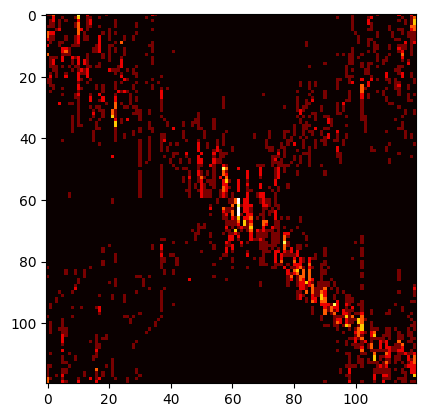

In [23]:
displayStats(cbm, "CATBOOST REV 3", X_test_Cr, y_test_Cr)

We can see that this classifier performs very poorly. The accuracy is extremely low, and while we can see some semblance of a primary diagonal in the confusion matrix, it is very scattershot, and is not clean. As such, using a singular classifier to classify this many classes may not be viable.

## Catboost Classifier - Revision 3

This version of rev 3 is based upon the second idea at the end of rev 2's conclusions. We will try to create a multi-classifier approach with the same architecture as revision 2. The key difference being that we will have multiple classifiers working together on a clip, instead of having a singular classifier responsible for the whole thing.

All of the following code is built on the assumption that each clip is 60 frames long.

1. Import the concatenated vector data so that we have an entire clip as a row

In [169]:
data_C = pd.read_csv("combined_concatVectors.csv",header=None)
data_C = data_C.sample(frac=1)
data_C = data_C.reset_index(drop=True)
labels_C = data_C[0]
data_C = data_C.drop(0,axis='columns')
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(data_C, labels_C, test_size=0.30, random_state=42)
X_train_C = X_train_C.to_numpy()
X_test_C = X_test_C.to_numpy()
y_train_C = np.asarray(y_train_C.values.tolist())
y_train_C = y_train_C.reshape(-1,1)
y_test_C = np.asarray(y_test_C.values.tolist())
y_test_C = y_test_C.reshape(-1,1)

In [170]:
print(pd.Series(labels_C).value_counts())
print(pd.Series(y_train_C.ravel()).value_counts())
print(pd.Series(y_test_C.ravel()).value_counts())

0.0    150
1.0    143
Name: 0, dtype: int64
0.0    106
1.0     99
dtype: int64
0.0    44
1.0    44
dtype: int64


In [171]:
print("NONCONCAT DATA SHAPES")
# print(data.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print("CONCAT DATA SHAPES")
# print(data_C.shape)
print(X_train_C.shape)
print(X_test_C.shape)
print(y_train_C.shape)
print(y_test_C.shape)

NONCONCAT DATA SHAPES
(6174, 34)
(2646, 34)
(6174, 1)
(2646, 1)
CONCAT DATA SHAPES
(205, 2040)
(88, 2040)
(205, 1)
(88, 1)


2. Reshape to extract frame-by-frame 

In [172]:
newdimx_train = (X_train_C.shape[0] * X_train_C.shape[1])/34
X_train_Cr = np.reshape(X_train_C,(int(newdimx_train),34))

newdimx_test = (X_test_C.shape[0]*X_test_C.shape[1])/34
X_test_Cr = np.reshape(X_test_C,(int(newdimx_test),34))

print("CONCAT DATA SHAPES AFTER RESHAPING")
print(X_train_Cr.shape)
print(X_test_Cr.shape)


CONCAT DATA SHAPES AFTER RESHAPING
(12300, 34)
(5280, 34)


3. Stretch the y-labels of training and test set to fit the reshaped arrays

In [173]:
print("LABEL SHAPES BEFORE STRETCHING")
print(y_train_C.shape)
print(y_test_C.shape)

y_train_Cr = np.copy(y_train_C)
y_test_Cr = np.copy(y_test_C)

y_train_Cr = np.repeat(y_train_Cr,(X_train_Cr.shape[0])/(y_train_Cr.shape[0]))
y_train_Cr = np.reshape(y_train_Cr,(-1,1))
y_test_Cr = np.repeat(y_test_Cr,(X_test_Cr.shape[0])/(y_test_Cr.shape[0]))
y_test_Cr = np.reshape(y_test_Cr,(-1,1))

print("LABEL SHAPES AFTER STRETCHING")
print(y_train_Cr.shape)
print(y_test_Cr.shape)

LABEL SHAPES BEFORE STRETCHING
(205, 1)
(88, 1)
LABEL SHAPES AFTER STRETCHING
(12300, 1)
(5280, 1)


4. Train 4 classifiers to fit on quarters of each clip
- Create 4 seperated datasets that comprise a quarter of the frames each.
- Create classifiers for each of the seperated datasets

In [174]:
frames_per_clip = int(y_train_Cr.shape[0] / y_train_C.shape[0]) #should evaluate to 60 frames

In [175]:
x_train_cr_splits = [[],[],[],[]]
y_train_cr_splits = [[],[],[],[]]
numclips = X_train_C.shape[0]
for i in range(numclips):
    clip = X_train_Cr[i*frames_per_clip:(i+1)*frames_per_clip] 
    labels = y_train_Cr[i*frames_per_clip:(i+1)*frames_per_clip]
    for i in range(4):
        subclip = clip[i*int(clip.shape[0]/4):(i+1)*int(clip.shape[0]/4)]
        sublabel = labels[i*int(labels.shape[0]/4):(i+1)*int(labels.shape[0]/4)]
        x_train_cr_splits[i] = x_train_cr_splits[i]+subclip.tolist()
        y_train_cr_splits[i] = y_train_cr_splits[i] + sublabel.tolist()

x_train_cr_splits = np.asarray(x_train_cr_splits)
y_train_cr_splits = np.asarray(y_train_cr_splits)
print(x_train_cr_splits.shape)
print(y_train_cr_splits.shape)

(4, 3075, 34)
(4, 3075, 1)


In [176]:
x_test_cr_splits = [[],[],[],[]]
y_test_cr_splits = [[],[],[],[]]
numclips = X_test_C.shape[0]
for i in range(numclips):
    clip = X_test_Cr[i*frames_per_clip:(i+1)*frames_per_clip]
    labels = y_test_Cr[i*frames_per_clip:(i+1)*frames_per_clip]
    for i in range(4):
        subclip = clip[i*int(clip.shape[0]/4):(i+1)*int(clip.shape[0]/4)]
        sublabel = labels[i*int(labels.shape[0]/4):(i+1)*int(labels.shape[0]/4)]
        x_test_cr_splits[i] = x_test_cr_splits[i]+subclip.tolist()
        y_test_cr_splits[i] = y_test_cr_splits[i] + sublabel.tolist()

x_test_cr_splits = np.asarray(x_test_cr_splits)
y_test_cr_splits = np.asarray(y_test_cr_splits)
print(x_test_cr_splits.shape)
print(y_test_cr_splits.shape)

(4, 1320, 34)
(4, 1320, 1)


In [177]:
from catboost import CatBoostClassifier
cbm1 = CatBoostClassifier(silent= True)
cbm2 = CatBoostClassifier(silent= True)
cbm3 = CatBoostClassifier(silent= True)
cbm4 = CatBoostClassifier(silent= True)

cbm1.fit(x_train_cr_splits[0],y_train_cr_splits[0])
cbm2.fit(x_train_cr_splits[1],y_train_cr_splits[1])
cbm3.fit(x_train_cr_splits[2],y_train_cr_splits[2])
cbm4.fit(x_train_cr_splits[3],y_train_cr_splits[3])

CBM1 STATS:
ACCURACY: 0.5787878787878787


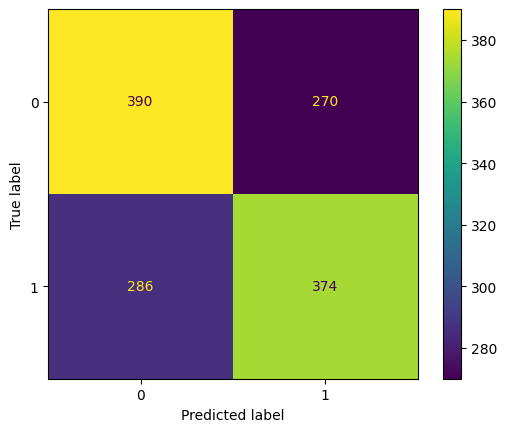

CBM2 STATS:
ACCURACY: 0.621969696969697


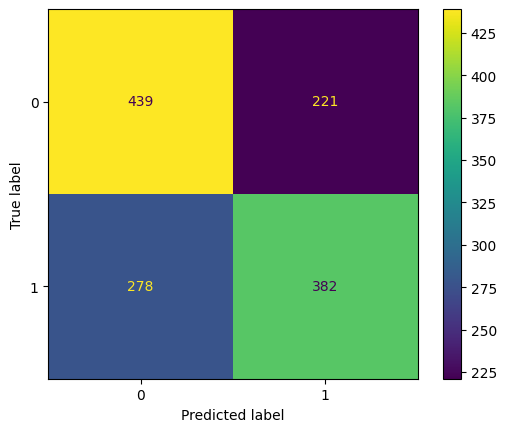

CBM3 STATS:
ACCURACY: 0.6227272727272727


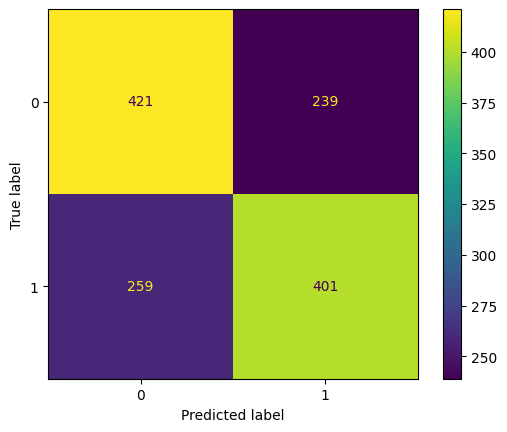

CBM4 STATS:
ACCURACY: 0.5871212121212122


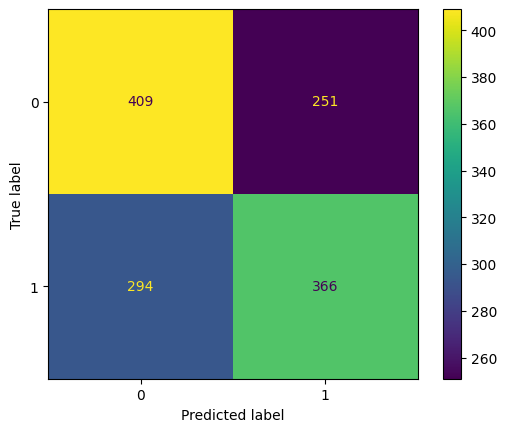

In [178]:
displayStats(cbm1,"CBM1",x_test_cr_splits[0],y_test_cr_splits[0])
displayStats(cbm2,"CBM2",x_test_cr_splits[1],y_test_cr_splits[1])
displayStats(cbm3,"CBM3",x_test_cr_splits[2],y_test_cr_splits[2])
displayStats(cbm4,"CBM4",x_test_cr_splits[3],y_test_cr_splits[3])

5) Classify 60 frames at a time (one clip) and take a majority consensus to classify a clip.

In [179]:
preds = []
softpreds = []
predictors=[cbm1,cbm2,cbm3,cbm4]
for clip in X_test_C: # go over all of the clips concat vectors in X_test_C
    clip = np.reshape(clip,(1,-1))
    numrows = int((clip.shape[0]*clip.shape[1])/34) #should be 60 for our standard, but this keeps it dynamic
    numcols = int((clip.shape[0]*clip.shape[1])/numrows) #should always end up as 34
    clip = np.reshape(clip,(numrows, numcols))

    subPredictions = [] #slice the clip into four sections, and generate a prediction for each of those sections
    subSoftPredictions = []
    for i in range(4):
        subclip = clip[
            int(i*(numrows/4)):
            int((i+1)*(numrows/4))
        ]
        predictions = predictors[i].predict(subclip) #frame by frame prediction vector with appropriate predictor
        softpredictions = predictors[i].predict(subclip) #frame by frame softpred vector with appropariate predictor
        softavgpred = np.average(subSoftPredictions) #average soft prediction
        prediction = np.sum(predictions) #create composite hard pred
        if(prediction < (predictions.shape[0]/2)):
            prediction = 0
        else:
            prediction = 1
        subPredictions.append(prediction)
        subSoftPredictions.append(softavgpred)

    #use sub predictions to make clip prediction
    clipPrediction = np.sum(subPredictions)
    if(clipPrediction<(len(subPredictions)/2)):
        clipPrediction = 0
    else:
        clipPrediction = 1

    clipSoftPred = np.average(subSoftPredictions)

    preds.append(clipPrediction)
    softpreds.append(clipSoftPred)
preds = np.asarray(preds)
softpreds = np.asarray(softpreds)

/home/sidharth/Documents/School/2022_2023/EE379K_ComputerVision/final_proj/Shot-Predictor/.venv/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/sidharth/Documents/School/2022_2023/EE379K_ComputerVision/final_proj/Shot-Predictor/.venv/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


6. Evaluate the accuracy of our predictions

ACCURACY: 0.6477272727272727


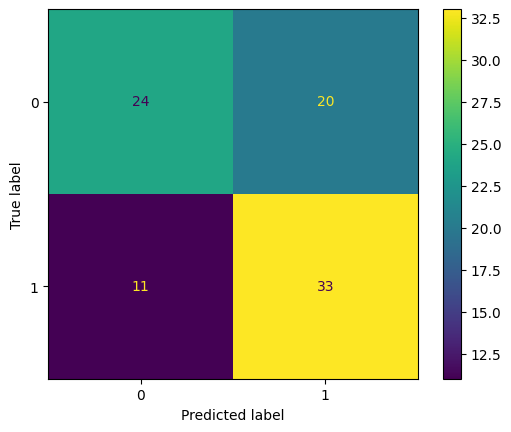

In [180]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

preds = np.reshape(preds,(-1,1))
print("ACCURACY: "+str(accuracy_score(y_test_C,preds)))
# print("ROC AUC: "+str(roc_auc_score(y_test_C,softpreds)))

cmat = confusion_matrix(y_test_C,preds)
disp = ConfusionMatrixDisplay(cmat)
disp.plot()
plt.show()